# WeatherPy
----
This notebook will be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, we'll be utilizing a [simple Python library](https://pypi.python.org/pypi/citipy), the [OpenWeatherMap API](https://openweathermap.org/api), and a little common sense to create a representative model of weather across world cities.![WeatherMeasures](../Images/OpenweatherAPI.png)

We will seek to find if there is a correlation between one of four weather measures and latitude. The four weather measures are Temperature, Humidity, Cloudiness and Wind Speed. Imperial units will be utilized.

Our first analysis will examine all latitudes against each weather measure. Then we will segment our dataset into Northern and Southern Hemisphere data and see if we are able to get a stronger correlation to the weather measures.

This final notebook will contain:

* At least 500 randomly selected unique (non-repeat) cities based on latitude and longitude.
* A weather check on each of the cities found randomly using a series of successive API calls to Openweather.org.
* A printed log of each city as it's being processed with the city ID and city name.
* A saved CSV file of all retrieved data
* A PNG image for each scatter plot (saved in the "Figures" folder)

# Analysis and observations

Of the four weather measures examined versus changes in latitude the strongest correlation was found between Northern Hemisphere changes in latitude versus temperature. This relationship had a high r-squared value of 0.87 meaning that 87% of the variance in this data could be explained by the equation of the line from linear regression. ![WeatherMeasures](Figures/NorthHemiLatVsTemp.png)

Of the relationships examined there were some weak correlations with r-squared values of around 0.4 and others below that - which indicated that there wasn't a correlation:
* Northern Hemisphere - Temperature (F) vs. Latitude     r-squared -0.87
* Southern Hemisphere - Temperature (F) vs. Latitude     r-squared  0.42     
* Northern Hemisphere - Humidity (%) vs. Latitude        r-squared  0.29
* Southern Hemisphere - Humidity (%) vs. Latitude        r-squared  0.42
* Northern Hemisphere - Cloudiness (%) vs. Latitude      r-squared  0.19
* Southern Hemisphere - Cloudiness (%) vs. Latitude      r-squared  0.39
* Northern Hemisphere - Wind Speed (mph) vs. Latitude    r-squared  0.07
* Southern Hemisphere - Wind Speed (mph) vs. Latitude    r-squared -0.41

Some observable trends based on this data:

* Temperature decreases as you move north from the equator in the Northern Hemisphere in strongly linear fashion
* Temperature decreases as you move south from the equator in the Southern Hemisphere in a weak linear fashion
* In the Northern Hemisphere Humidity is very weakly correlated to increase as you increase in latitude
* In the Southern Hemisphere Humidity is weakly correlated to decrease as you move south in latitude
* Cloudiness is not correlated to latitude in the Northern Hemisphere
* Cloudiness is weakly correlated to decrease as you move south in latitude in the Southern Hemisphere
* Wind Speed is not correlated to latitude in the Northern Hemisphere
* In the Southern Hemisphere, Wind Speed is weakly correlated to increase as you move south in latitude


# Import dependencies, API key and set output file name

In [76]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from config import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Generate Cities List

We will generate a list of random latitude,longitude pairs as "seed" values to pass into the citypy package. Citypy uses the latitude, longitude values to return the closest city from a list of all cities in the world - these are then saved into a list of cities and the country codes (which we then combine into a list of tuples with the zip function)

In [80]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# List for holding lat_lngs and cities
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations and zip into a list of tuples
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination using the Citypy package to return a unique city and country code
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Combine the two lists into a list of tuples using the zip function
city_country = zip(cities,countries)

# Print the city count to confirm sufficient count ( Greater than 500 )
print(len(cities))


618


# Perform API Calls

* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).
* Export all the city data into a .csv.


In [81]:
# Save config information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# set up lists to hold reponse info
city_id = []
city_name = []
country = []
latitude = []
longitude = []
weather_date = []
temp = []
humidity = []
cloudiness = []
wind_speed = []

# Open file to write results of API calls - success or not into a txt file, as well as all data pulled into a csv
myprintlog = open('weatherAPI_printlog.txt', 'w')
myAPIdata = open('weatherAPI_data.csv', 'w')

# Write header line for csv file
myAPIdata.write("city_id,city_name,country,latitude,longitude,weather_date,temp,humidity,cloudiness,wind_speed\n")

# Loop through the list of tuples of cities,country codes and perform a request for data on each
for city,country_code in city_country:
    query_url = f"{url}appid={api_key}&q={city},{country_code}&units={units}"
    response = requests.get(query_url).json()

    # Try to grab the temp,humidity,cloudiness and wind speed if they are available in the Weather API
    # if the city is not found on the WeatherAPI site then the "except" will catch the error and the loop will
    # continue to go through the rest of the city,country_codes in the city_country list
    try:
        # Create variables for each response item and format to desired datatype
        cityID = int(response['id'])
        cityName = response['name']
        countryCode = response['sys']['country']
        lat_val = response['coord']['lat']
        lon_val = response['coord']['lon']
        weatherDate = (datetime.fromtimestamp(response['dt'])).strftime('%m/%d/%y')
        temperature = response['main']['temp']
        humidity_val = response['main']['humidity']
        cloudiness_val = response['clouds']['all']
        windSpeed = response['wind']['speed']
        
        # Append retreived values to lists above using the variables created above
        city_id.append(cityID)
        city_name.append(cityName)
        country.append(countryCode)
        latitude.append(lat_val)
        longitude.append(lon_val)
        weather_date.append(weatherDate)
        temp.append(temperature)
        humidity.append(humidity_val)
        cloudiness.append(cloudiness_val)
        wind_speed.append(windSpeed)
        
        # Output line to terminal to mark progress and store it to a print log text file
        print(f"{cityName} with city ID:{cityID} was found in the Weathermap API\n")
        myprintlog.write(f"{cityName} with city ID:{cityID} was found in the Weathermap API\n")
        
        # Output all retreived values to a csv file
        myAPIdata.write(f"{cityID},{cityName},{countryCode},{lat_val},{lon_val},{weatherDate},\
            {temperature},{humidity_val},{cloudiness_val},{windSpeed}\n")
        
    # Handle exceptions for a city that is not available in the Weather API
    except:
        
        print(f"{city},{country_code} was not found in the Weathermap API\n")
        myprintlog.write(f"{city},{country_code} was not found in the Weathermap API\n")
        
        # Append null values so lists are all the same length (later we will remove nulls from dataframe)
        city_id.append(None)
        city_name.append(None)
        country.append(None)
        latitude.append(None)
        longitude.append(None)
        weather_date.append(None)
        temp.append(None)
        humidity.append(None)
        cloudiness.append(None)
        wind_speed.append(None)
        pass
    
# Close the file handle after completion of the loop
myprintlog.close()
myAPIdata.close()

Tasiilaq with city ID:3424607 was found in the Weathermap API

Halifax with city ID:6324729 was found in the Weathermap API

Jamestown with city ID:3370903 was found in the Weathermap API

Dikson with city ID:1507390 was found in the Weathermap API

Puerto Ayora with city ID:3652764 was found in the Weathermap API

Cape Town with city ID:3369157 was found in the Weathermap API

Mar del Plata with city ID:3430863 was found in the Weathermap API

sug-aksy,ru was not found in the Weathermap API

potgietersrus,za was not found in the Weathermap API

Albany with city ID:2077963 was found in the Weathermap API

Bluff with city ID:2206939 was found in the Weathermap API

Nouadhibou with city ID:2377457 was found in the Weathermap API

Bonavista with city ID:5905393 was found in the Weathermap API

Katsuura with city ID:2112309 was found in the Weathermap API

Constitucion with city ID:4011743 was found in the Weathermap API

Kodiak with city ID:5866583 was found in the Weathermap API

Chokurd

Misratah with city ID:2214846 was found in the Weathermap API

Matay with city ID:352628 was found in the Weathermap API

Gamovo with city ID:562070 was found in the Weathermap API

bolungarvik,is was not found in the Weathermap API

Adrar with city ID:2508807 was found in the Weathermap API

Jeremie with city ID:3723593 was found in the Weathermap API

Funadhoo with city ID:1337620 was found in the Weathermap API

illoqqortoormiut,gl was not found in the Weathermap API

Gubkinskiy with city ID:1539209 was found in the Weathermap API

Kaitangata with city ID:2208248 was found in the Weathermap API

ozgon,kg was not found in the Weathermap API

Harper with city ID:2276492 was found in the Weathermap API

Fort Nelson with city ID:5955902 was found in the Weathermap API

Zahesi with city ID:611093 was found in the Weathermap API

Usinsk with city ID:863061 was found in the Weathermap API

goderich,sl was not found in the Weathermap API

Raudeberg with city ID:3146487 was found in the Weat

Raduzhny with city ID:1540356 was found in the Weathermap API

Ciudad de Armeria with city ID:4018227 was found in the Weathermap API

Nikitinskiy with city ID:1497736 was found in the Weathermap API

Nome with city ID:5870133 was found in the Weathermap API

nizhneyansk,ru was not found in the Weathermap API

Lopik with city ID:2751436 was found in the Weathermap API

Cockburn Town with city ID:3576994 was found in the Weathermap API

Perry with city ID:4303951 was found in the Weathermap API

Kenora with city ID:5991056 was found in the Weathermap API

Kattivakkam with city ID:1267433 was found in the Weathermap API

Coyhaique with city ID:3894426 was found in the Weathermap API

Ngara with city ID:151711 was found in the Weathermap API

Vilyuysk with city ID:2013392 was found in the Weathermap API

Gerash with city ID:133595 was found in the Weathermap API

Vrangel with city ID:2013258 was found in the Weathermap API

Akdagmadeni with city ID:324768 was found in the Weathermap API



Vestmannaeyjar with city ID:3412093 was found in the Weathermap API

Bakchar with city ID:1511057 was found in the Weathermap API

Hamilton with city ID:3573197 was found in the Weathermap API

Harrisburg with city ID:5192726 was found in the Weathermap API

Lyman with city ID:704204 was found in the Weathermap API

Grindavik with city ID:3416888 was found in the Weathermap API

Puerto Leguizamo with city ID:3671437 was found in the Weathermap API

Fukuecho with city ID:1863997 was found in the Weathermap API

Karagay with city ID:552887 was found in the Weathermap API

jarjis,tn was not found in the Weathermap API

Nandurbar with city ID:1261931 was found in the Weathermap API

Puerto Carreno with city ID:3671519 was found in the Weathermap API

faya,td was not found in the Weathermap API

Kidodi with city ID:157826 was found in the Weathermap API

Mount Isa with city ID:2065594 was found in the Weathermap API

Port Shepstone with city ID:964406 was found in the Weathermap API

Andila

Waingapu with city ID:1622318 was found in the Weathermap API

Westport with city ID:2960970 was found in the Weathermap API

Sfantu Gheorghe with city ID:667303 was found in the Weathermap API

New Iberia with city ID:4334971 was found in the Weathermap API

Dhanaura with city ID:1272983 was found in the Weathermap API

Buchanan with city ID:2278158 was found in the Weathermap API

Abha with city ID:110690 was found in the Weathermap API

Anchorage with city ID:5879400 was found in the Weathermap API

Biak with city ID:1637001 was found in the Weathermap API

kapoeta,sd was not found in the Weathermap API

Husavik with city ID:2629833 was found in the Weathermap API

Dunedin with city ID:2191562 was found in the Weathermap API

Kibungo with city ID:202068 was found in the Weathermap API

Namie with city ID:2111704 was found in the Weathermap API

Waconia with city ID:5051640 was found in the Weathermap API

San Borja with city ID:3905792 was found in the Weathermap API

Pindiga with c

### Convert Raw Data to DataFrame
* Display the DataFrame

In [85]:
# create a dictionary from the lists that we created above
weather_dict = {
    "city_id": city_id,
    "city_name": city_name,
    "country": country,
    "latitude": latitude,
    "longitude": longitude,
    "weather_date": weather_date,
    "temp": temp,
    "humidity": humidity,
    "cloudiness": cloudiness,
    "wind_speed": wind_speed
}

# Use the dictionary to create a dataframe named weather_data
weather_data = pd.DataFrame(weather_dict)
weather_data.head()

,city_id,city_name,country,latitude,longitude,weather_date,temp,humidity,cloudiness,wind_speed
0,3424607.0,Tasiilaq,GL,65.61,-37.64,01/25/20,30.20,63.0,100.0,25.28
1,6324729.0,Halifax,CA,44.65,-63.57,01/25/20,29.21,92.0,90.0,16.11
2,3370903.0,Jamestown,SH,-15.94,-5.72,01/25/20,75.20,75.0,100.0,14.63
3,1507390.0,Dikson,RU,73.51,80.55,01/25/20,-7.82,96.0,100.0,7.07
4,3652764.0,Puerto Ayora,EC,-0.74,-90.35,01/25/20,77.90,78.0,75.0,8.05


In [86]:
# Make a dataframe that has only non-null values (so linear regression can be done later)
# First drop the NaN values
weather_data_values = weather_data.dropna()

# Reset the index (it will have gaps in it where the NaN value rows have been deleted)
weather_data_values = weather_data_values.reset_index(drop=True)

# Change the datatype for the city_id field to an integer (it gets created as a float)
weather_data_values['city_id'] = weather_data_values['city_id'].astype(int)
#weather_data_values.head()

# Plotting the Data as Scatterplots to discern any patterns

We will build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude


Plots will be labeled with plot titles (including date of analysis) and axes labels and then
saved to the figures folder as .pngs

## Latitude vs. Temperature Plot

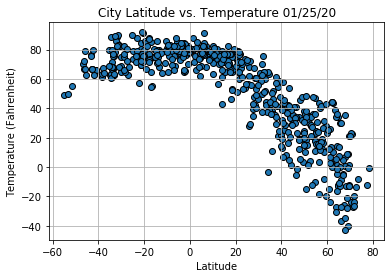

In [87]:
# Build a scatter plot for Latitude vs.Temperature in Fahrenheit
weatherDate = weather_data_values['weather_date'][0]
plt.scatter(weather_data_values["latitude"], weather_data_values["temp"], marker="o",edgecolors='black')

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Temperature {weatherDate}")
plt.ylabel("Temperature (Fahrenheit)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Figures/LatitudeVsTemperature.png")

# Show plot
plt.show()

The Latitude vs. Temperature plot has an unexpected result. As you move north of the equator from a latitude of 0 to a latitude of 80 you see what appears to be a linear decrease in temperature from 70 degrees Fahrenheit to -40 degrees Fahrenheit from 20 degrees latitude to around 80 degrees latitude. 

However, we do not see much of a drop moving south of the equator from 0 degrees latitude to around -55 degrees latitude. One reason for this is that there are so few cities in the southern hemisphere, but that can't fully account for the observation since from 0 to -40 we don't see any reduction in temperature (although there are ample cities). This compare to moving from 0 to 40 degrees latitude, where we see around a 40 degree drop in temperature.

## Latitude vs. Humidity Plot

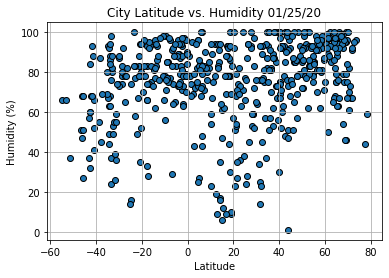

In [89]:
# Build a scatter plot for Latitude vs. Humidity
plt.scatter(weather_data_values["latitude"], weather_data_values["humidity"], marker="o",edgecolors='black')

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Humidity {weatherDate}")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Figures/LatitudeVsHumidity.png")

# Show plot
plt.show()

The Latitude vs. Humidity plot does not seem to have a strong correlation to latitude. One can say however, that it appears more cities have a humidity above 60% than a humidity below 60%. It will be interesting to see if grouping by Northern vs. Southern Hemispheres will tease this cluster apart to reveal a trend.

## Latitude vs. Cloudiness Plot

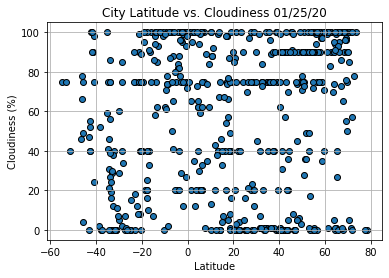

In [90]:
# Build a scatter plot for Latitude vs. Cloudiness
plt.scatter(weather_data_values["latitude"], weather_data_values["cloudiness"], marker="o",edgecolors='black')

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Cloudiness {weatherDate}")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Figures/LatitudeVsCloudiness.png")

# Show plot
plt.show()

The Latitude vs. Cloudiness plot does not seem to have any correlation to latitude. One can say however, that there seems to be a collection of points across all latitudes at either 0%, 75% or 100% Cloudy. I'd be curious if this measure is subjective or objective. I'd expect a subjective assesment to yield more 0%,25%,50% and 100% observations. An objective assesment would have a more even distribution. Given the "lines" we see at discreet %Cloudiness levels across all latitudes, I'd guess this measure is a subjective measurement.

## Latitude vs. Wind Speed Plot

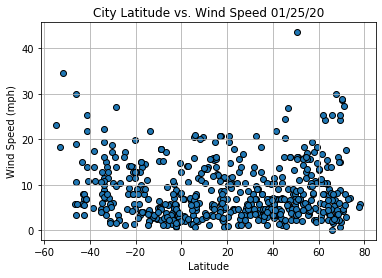

In [91]:
# Build a scatter plot for Latitude vs. Wind Speed
plt.scatter(weather_data_values["latitude"], weather_data_values["wind_speed"], marker="o",edgecolors='black')

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Wind Speed {weatherDate}")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("Figures/LatitudeVsWindSpeed.png")

# Show plot
plt.show()

The Latitude vs. Wind Speed scatterplot suggests there is no correlation between Wind Speed and Latitude. One can say that regardless of latitude we see the vast majority of wind speed between 0-20 mph, with most of those falling into the 0-10 mph range.

# Linear Regression Scatterplots for the Northern vs. Southern Hemispheres

Our next objective is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude). The scatterplots we will create are:

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude



## Create a function to accept arguments and create a linear regression scatterplot

This function will accept a number of arguments and return a linear regression scatterplot that saves a figure to the figure folder.

In [97]:
# OPTIONAL: Create a function to create Linear Regression plots

# Make a function that accepts a list of x values and y values, a description for the x and y axes,
# a string that describes which hemisphere is being analyzed and a filename to use while saving the figure
# and finally the x,y coordinates to create the annotation of the equation on the graph
def make_lin_reg_plot(x_values,y_values,x_desc,y_desc,hemisphere,filename,x_ann,y_ann):
    # Print out the r-squared value along with the plot.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values,edgecolors='black')
    plt.plot(x_values,regress_values,"r-")
    plt.title(f"{hemisphere}-\nCity {x_desc} vs. {y_desc} {weatherDate}")
    plt.annotate(line_eq,(x_ann,y_ann),fontsize=15,color="red")
    plt.xlabel(x_desc)
    plt.ylabel(y_desc)
    print(f"The r-squared is: {rvalue}")
    print(line_eq)
    plt.savefig(f'Figures/{filename}')
    plt.show()

## Create subset dataframes for Northern and Southern Hemispheres

In [94]:
# Create Northern and Southern Hemisphere DataFrames
# store the boolean criteria in a variable to pass to the dataframe indexing function
crit_north = weather_data_values.latitude >= 0
crit_south = weather_data_values.latitude < 0

# Create the north and south hemisphere dataframes using boolean indexing from the criteria from above 
north_weather = weather_data_values[crit_north]
south_weather = weather_data_values[crit_south]

# The indexes will not be continuous so they need to be reset with the drop=True argument so we don't make
# the prior index as a column
north_weather = north_weather.reset_index(drop=True)
south_weather = south_weather.reset_index(drop=True)
#north_weather.head()

##  Northern Hemisphere - Temp vs. Latitude Linear Regression

The r-squared is: -0.8739311342091678
y = -1.32x + 89.65


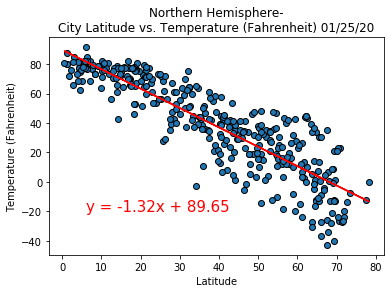

In [100]:
make_lin_reg_plot(north_weather["latitude"],north_weather["temp"],\
                  'Latitude','Temperature (Fahrenheit)','Northern Hemisphere',\
                 'NorthHemiLatVsTemp.png',6,-20)

This scatterplot with linear regression has and r-squared value of -0.87, so there is a strong negative linear relationship between decreasing latitude and decreasing temperature in the Northern Hemisphere. This means 87% of the variance is explained by this linear model, which is very good. Keep in mind that if the model explained 100% of the variance, all the points would have to be on the curve.

##  Southern Hemisphere - Temp vs. Latitude Linear Regression

The r-squared is: 0.42249663763786
y = 0.25x + 80.05


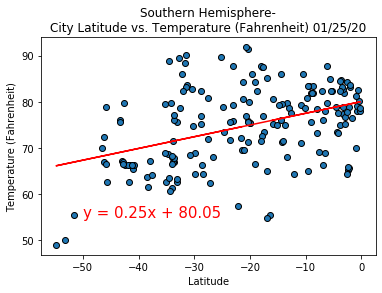

In [102]:
make_lin_reg_plot(south_weather["latitude"],south_weather["temp"],\
                  'Latitude',f'Temperature (Fahrenheit)','Southern Hemisphere',\
                 'SouthHemiLatVsTemp.png',-50,55)

This scatter plot shows a weaker relationship between temperature and latitude in the Southern Hemisphere, with an r-squared value of 0.42. This means the linear curve fit can only account for 42% of the variance seen in the data, leaving the majority of the variance unexplained by the equation of the line y = 0.25x + 80.05. So, although there seems to be a correlation it is weak at best.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.29137218774775864
y = 0.3x + 65.17


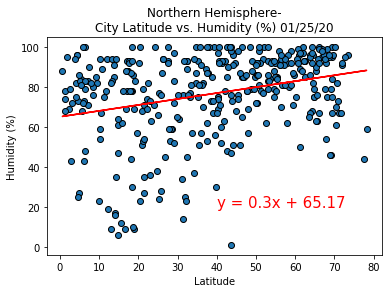

In [103]:
make_lin_reg_plot(north_weather["latitude"],north_weather["humidity"],\
                  'Latitude',f'Humidity (%)','Northern Hemisphere',\
                 'NorthHemiLatVsHumidity.png',40,20)

This scatter plot shows a very weak relationship between latitude and humidity in the Northern Hemisphere with an r-squared value of 0.29. This means the linear curve fit can only account for 29% of the variance seen in the data, leaving the vast majority of the variance unexplained by the equation of the line y = 0.3x + 65.17. So, although there seems to be a correlation it is very weak and I would conclude there is little correlation between latitude and humidity in the Northern Hemisphere.

##  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.4245631205677513
y = 0.56x + 85.42


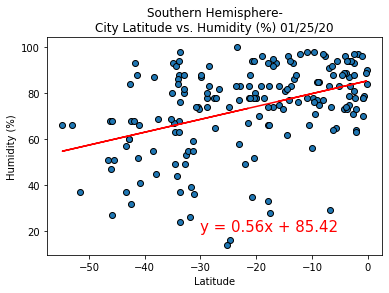

In [105]:
make_lin_reg_plot(south_weather["latitude"],south_weather["humidity"],\
                  'Latitude',f'Humidity (%)','Southern Hemisphere',\
                 'SouthHemiLatVsHumidity.png',-30,20)

In the Southern Hemisphere there is a weak correlation between latitude and humidity. The linear regression has an r-squared value of 0.42 - meaning 42% of the variance in the data is explained by the curve fit. This is not a strong correlation, but rather a weak one, but we can't say there is no correlation. Other factors play the majority of the role in the change in humidity.

##  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.1858558085059614
y = 0.34x + 44.93


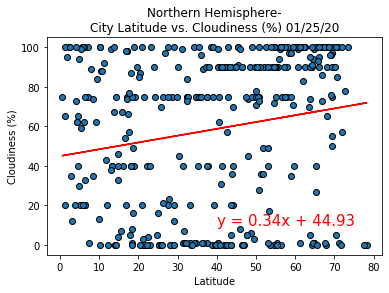

In [107]:
make_lin_reg_plot(north_weather["latitude"],north_weather["cloudiness"],\
                  'Latitude',f'Cloudiness (%)','Northern Hemisphere',\
                 'NorthHemiLatVsCloudiness.png',40,10)

In the Northern Hemisphere there does not seem to be a significant correlation between latitude and cloudiness. The linear regression curve fit yields an equation of the line with an r-squared value of only 0.185 - meaning the linear equation of the line only explains 18.5% of the variance seen. Visually we can confirm what the math indicates - that there is really no correlation between the latitude and cloudiness in the Northern Hemisphere.

##  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.3883762271585566
y = 0.98x + 76.88


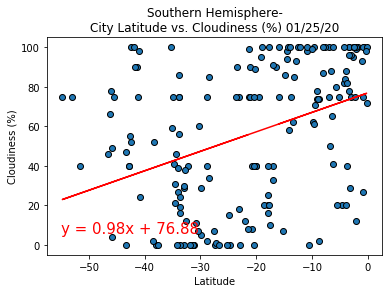

In [110]:
make_lin_reg_plot(south_weather["latitude"],south_weather["cloudiness"],\
                  'Latitude',f'Cloudiness (%)','Southern Hemisphere',\
                 'SouthHemiLatVsCloudiness.png',-55,6)

In the Southern Hemisphere, latitude weakly correlates with cloudiness with and equation of the linear regression yielding an r-squared value of 0.39 - or 39% of the variance of the observed data can be accounted for by the equation of the linear regression line. This is a weak correlation. By looking at the data I would not have guessed that we would even see a number that high - I'd guess it was an r-squared in the teens. 

##  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.0743656769453148
y = 0.02x + 7.56


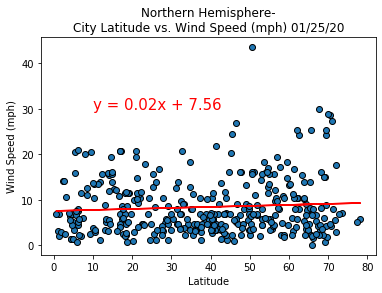

In [111]:
make_lin_reg_plot(north_weather["latitude"],north_weather["wind_speed"],\
                  'Latitude',f'Wind Speed (mph)','Northern Hemisphere',\
                 'NorthHemiLatVsWindSpeed.png',10,30)

There is almost no correlation between latitude and wind speed in the Northern Hemisphere. The linear regression gives us the weakest r-squared value of all the scatterplots we have examined thus far - 0.07. Only 7% of the variance can be accounted for by the equation of the line - so for all practical purposes there isn't a linear correlation between these two factors.

##  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.41061374271441403
y = -0.18x + 4.79


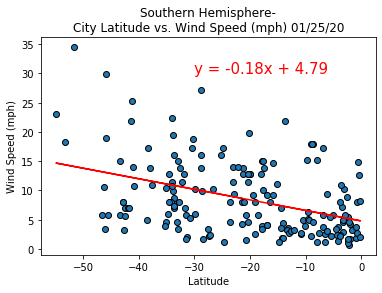

In [113]:
make_lin_reg_plot(south_weather["latitude"],south_weather["wind_speed"],\
                  'Latitude',f'Wind Speed (mph)','Southern Hemisphere',\
                 'SouthHemiLatVsWindSpeed.png',-30,30)

In the Southern Hemisphere we see a much stronger correlation between latitude and wind speed with an r-squared value of -0.41. But this is still weak and it is saying that the majority (59%) of the variance cannot be explained by the linear regression curve fit. I would feel confident about saying that there is a weak correlation between latitude and wind speed in the Southern Hemisphere - as you move away from the equator towards the south pole wind speed increase. Since there are so few cities south of -50 degrees latitude, this also may be a function of sparse data. It is well know that the south pole is a "permanent storm". I would expect that if there were cities in that region of the world that they would be incredibly windy!